In [1]:
import ee
import cartoee as cee
import cartopy.crs as ccrs

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ee.Initialize()

In [3]:
# get an earth engine image
srtm = ee.Image("CGIAR/SRTM90_V4")

In [4]:
# specify visualization parameters and region to map
visualization = {'min':-500,'max':3000,'bands':'elevation'}
bbox = [-180,-90,180,90]

In [5]:
ax = cee.getMap(srtm,region=bbox,visParams=visualization,dims=4000)
ax.coastlines()
plt.show()

/home/manmeet/anaconda3/envs/gee/lib/python2.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


In [6]:
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.pyplot as plt
# plot the map
ax = cee.getMap(srtm,cmap='terrain',region=bbox,visParams=visualization,dims=4000)
# add a color bar using cartoee
#cb = cee.addColorbar(ax,loc='right',cmap=matplotlib.colors.Colormap('terrain'),visParams=visualization)
cb = cee.addColorbar(ax,loc='right',cmap=plt.cm.terrain,visParams=visualization)

ax.coastlines()

# set gridlines and spacing
xticks = [-180,-120,-60,0,60,120,180]
yticks = [-90,-60,-30,0,30,60,90]
ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--')

# set custom formatting for the tick labels
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

# set tick labels
ax.set_xticks([-180,-120,-60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

plt.show()

In [7]:

# specify new region over Colorado
# showing the Great Continental Divide that splits the state
newRegion = [-111,35,-100,43]

ax = cee.getMap(srtm,cmap='terrain',region=newRegion,visParams=visualization,
               dims=2000)

# add a colorbar to our map
cb = cee.addColorbar(ax,loc='right',cmap=plt.cm.terrain,visParams=visualization)

# add a marker for Denver,CO
ax.plot(-104.9903,39.7392,'ko')
ax.text(-104.9,39.78,'Denver,CO')

plt.show()

In [8]:
# send a processing request to EE
# calcualte a hillshade from SRTM data and specify the visualization
hillshade = ee.Terrain.hillshade(srtm,azimuth=285,elevation=30)

#create new visualization parameters for the hillshade and elevation data
hsVis = {'min':25,'max':200,'palette':'000000,ffffff'}
elvVis = {'min':0,'max':3000,'opacity':0.5}

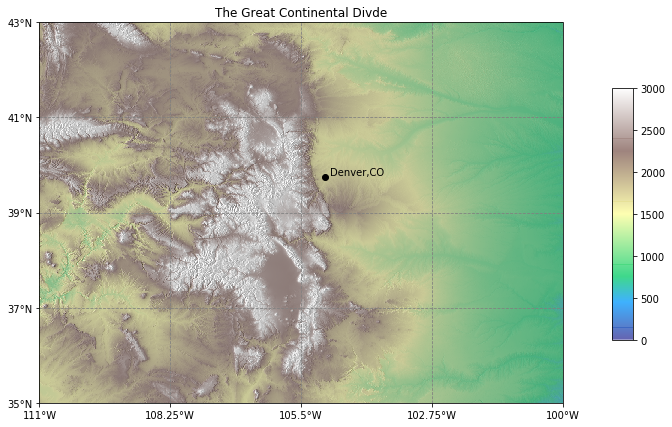

In [9]:
# set up a blank map
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(projection=ccrs.PlateCarree())

# plot our hillshade on the blank map
# *note: we are using the cee.addLayer function here and
#        passing our map into addLayer as a keyword. This
#        will get that map with the image overlayed
ax = cee.addLayer(hillshade,ax=ax,region=newRegion
                  ,visParams=hsVis,dims=[2000,1000])

# plot SRTM data over the hillshade with some adjusted visualization parameters
# *note: we are passing the map variable again as a keyword
#        into the addLayer function to stack images on each other
ax = cee.addLayer(srtm,ax=ax, cmap=plt.cm.terrain,region=newRegion,
              visParams=elvVis,dims=[2000,1000])

cax = ax.figure.add_axes([0.8,0.25,0.02,0.5])
cb = cee.addColorbar(ax,cax=cax,cmap=plt.cm.terrain,visParams=elvVis)

# add some styling to make our map publication ready
xticks = np.linspace(-111,-100,5)
yticks = np.linspace(35,43,5)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',color='gray')
# set custom formatting for the tick labels
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

# set a title so we know where it is
ax.set_title('The Great Continental Divde')

# add a marker for Denver,CO
ax.plot(-104.9903,39.7392,'ko')
ax.text(-104.9,39.78,'Denver,CO')

plt.show()


In [10]:
# get an earth engine image of ocean data for 2018
ocean = ee.ImageCollection('NASA/OCEANDATA/MODIS-Terra/L3SMI')\
        .filter(ee.Filter.date('2018-01-01', '2019-01-01')).median()

In [11]:
# set parameters for plotting
# will plot the Sea Surface Temp with specific range and colormap
visualization = {'bands':'sst','min':-2,'max':30}
# specify region to focus on
bbox = [-180,-90,180,90]

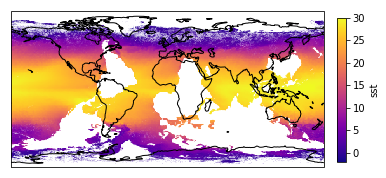

In [12]:
# plot the result with cartoee using a PlateCarre projection (default)
ax = cee.getMap(ocean,cmap=plt.cm.plasma,visParams=visualization,region=bbox)
cb = cee.addColorbar(ax,loc='right',cmap=plt.cm.plasma,visParams=visualization)

ax.coastlines()
plt.show()

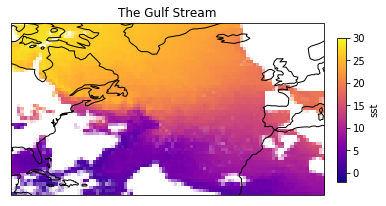

In [13]:

# Create a new region to focus on
natlantic = [-90,15,10,70]

# plot the result with cartoee focusing on the north Atlantic
ax = cee.getMap(ocean,cmap=plt.cm.plasma,visParams=visualization,region=natlantic)
cb = cee.addColorbar(ax,loc='right',cmap=plt.cm.plasma,visParams=visualization,)

ax.coastlines()
ax.set_title('The Gulf Stream')
plt.show()

In [14]:
# function to add NDVI band to imagery
def calc_ndvi(img):
    ndvi = img.normalizedDifference(['Nadir_Reflectance_Band2','Nadir_Reflectance_Band1'])
    return img.addBands(ndvi.rename('ndvi'))

In [15]:
# MODIS Nadir BRDF-Adjusted Reflectance with NDVI band
modis = ee.ImageCollection('MODIS/006/MCD43A4')\
        .filterDate('2010-01-01','2016-01-01')\
        .map(calc_ndvi)

In [16]:
# set parameters for plotting
ndviVis = {'min':0,'max':1,'bands':'ndvi'}
bbox = [-180,-60,180,90]

In [17]:
# get land mass feature collection
land = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

# calculate seasonal averages and clip to land features
djf = modis.filter(ee.Filter.calendarRange(12,3,'month')).mean().clip(land)
mam = modis.filter(ee.Filter.calendarRange(3,6,'month')).mean().clip(land)
jja = modis.filter(ee.Filter.calendarRange(6,9,'month')).mean().clip(land)
son = modis.filter(ee.Filter.calendarRange(9,12,'month')).mean().clip(land)

In [18]:
# get a country FeatureCollection
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
# filter the countries for a specific county
country = 'Senegal'
senegal = ee.Feature(countries.filter(ee.Filter.eq('country_na',country)).first())
# create an ee.Image from a FeatureCollection
adminImg = ee.Image().paint(countries,color='#000000',width=4)

# get a Landsat mosaic for West Africa
waLandsat = ee.Image('projects/servir-wa/regional_west_africa/Landsat_SR/Landsat_SR_prewet_2012_2014')
# specify the visualization parameters
lsVis = {'min':50,'max':5500,'gamma':1.5,'bands':'swir2,nir,green'}

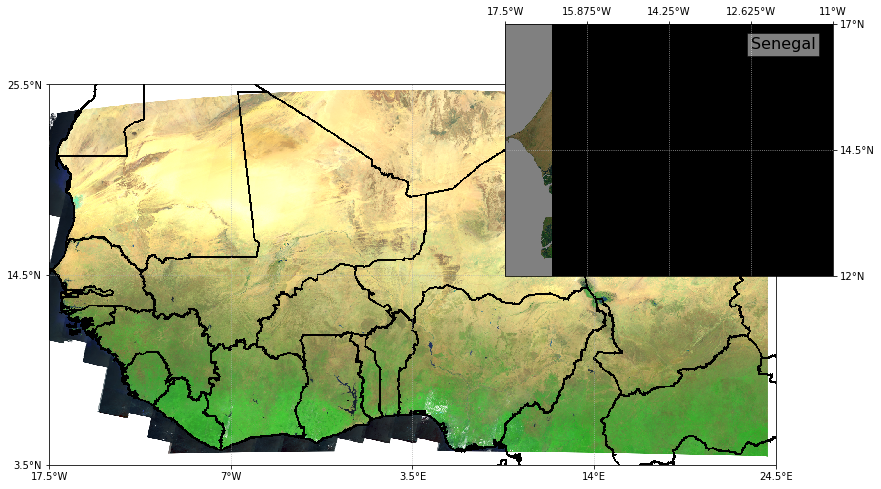

In [19]:
# import some styling functions
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

# setup blank figure
fig = plt.figure(figsize=(15,7))

# region for the main map
mainBox = [-17.5,3.5,24.5,25.5]

# set blank map for the main plot and add layers
ax_main = fig.add_subplot(1, 1, 1,projection=ccrs.PlateCarree())
ax_main = cee.addLayer(waLandsat,visParams=lsVis,region=mainBox,dims=2500,ax=ax_main)
ax_main = cee.addLayer(adminImg,region=mainBox,dims=1500,ax=ax_main)

# main map styling
xmain = np.linspace(-17.5,24.5,5)
ymain = np.linspace(3.5,25.5,3)
ax_main.gridlines(xlocs=xmain, ylocs=ymain,linestyle=':')
# set custom formatting for the tick labels
ax_main.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax_main.yaxis.set_major_formatter(LATITUDE_FORMATTER)
# set tick labels
ax_main.set_xticks(xmain, crs=ccrs.PlateCarree())
ax_main.set_yticks(ymain, crs=ccrs.PlateCarree())


# region for the map inset
insetBox = [-17.5,12,-11,17]

# setup inset map and add layers
ax_inset = fig.add_axes([0.45, 0.5, 0.6, 0.5],projection=ccrs.PlateCarree())
ax_inset = cee.addLayer(waLandsat.clip(senegal),visParams=lsVis,region=insetBox,dims=2500,ax=ax_inset)
ax_inset = cee.addLayer(adminImg,region=insetBox,ax=ax_inset)

# inset map styling
xinset = np.linspace(-17.5,-11,5)
yinset = np.linspace(12,17,3)
ax_inset.gridlines(xlocs=xinset, ylocs=yinset,linestyle=':')
# set custom formatting for the tick labels
ax_inset.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax_inset.yaxis.set_major_formatter(LATITUDE_FORMATTER)
ax_inset.xaxis.tick_top()
ax_inset.yaxis.tick_right()
# set inset tick labels
ax_inset.set_xticks(xinset, crs=ccrs.PlateCarree())
ax_inset.set_yticks(yinset, crs=ccrs.PlateCarree())

# add some text to the inset as a pseudo-title
ax_inset.text(-12.63,16.5,country,fontsize=16,bbox=dict(facecolor='white', alpha=0.5,edgecolor='k'))

plt.show()

In [20]:
import ee
import numpy as np
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize()


# Define an image.
img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038029_20180810') \
  .select(['B4', 'B5', 'B6'])

# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[-110.8, 44.7],
    [-110.8, 44.6],
    [-110.6, 44.6],
    [-110.6, 44.7]]], None, False)

# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B4')
band_arr_b5 = band_arrs.get('B5')
band_arr_b6 = band_arrs.get('B6')

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
np_arr_b5 = np.expand_dims(np_arr_b5, 2)
np_arr_b6 = np.expand_dims(np_arr_b6, 2)
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b6, np_arr_b5, np_arr_b4), 2)
print(rgb_img.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((rgb_img - 100)/3500)).astype('uint8')
plt.imshow(rgb_img_test)
plt.show()

Enter verification code: 4/1AY0e-g5U28cQKR_0QUSnSHEWMwK5GIyaQkM5FK4t2HDn-mNV2AfMok_jkpc

Successfully saved authorization token.
(373, 531)
(373, 531)
(373, 531)
(373, 531, 1)
(373, 531, 1)
(373, 531, 1)
(373, 531, 3)


In [21]:
latlon = ee.Image.pixelLonLat().addBands(band_arrs)

In [22]:
import ee 
import numpy as np

ee.Initialize()

date_start = ee.Date('2004-05-01')
end_date = ee.Date('2004-06-12')

area = ee.FeatureCollection(r'users/bcoerver/gadm36_PSE_0')

# define the image
img = ee.ImageCollection('MODIS/MCD43A4_006_NDVI').filterDate(date_start, end_date)

median_data = img.median()

# get the lat lon and add the ndvi
latlon = ee.Image.pixelLonLat().addBands(median_data)

# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=area,
  scale=100);

# get data into three different arrays
data = np.array((ee.Array(latlon.get("NDVI")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))

In [23]:
import ee
import numpy as np
ee.Initialize()
bounds = [-97.94, 26.81, -97.52, 26.9] ## sample land / sea bounds
area = ee.Geometry.Rectangle(bounds)
img = ee.Image('USGS/SRTMGL1_003')
latlng = ee.Image.pixelLonLat().addBands(img)
latlng = latlng.reduceRegion(reducer=ee.Reducer.toList(), geometry=area, maxPixels=1e8, scale=20)
lats = np.array((ee.Array(latlng.get("latitude")).getInfo()))
lngs = np.array((ee.Array(latlng.get("longitude")).getInfo()))
try:
    elev_values = np.array((ee.Array(latlng.get("elevation")).getInfo()))
except:
    elev_values = np.full_like(lats, np.nan,dtype=np.float64)
print(list(elev_values)) ## print as list to check

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
import ee
import numpy as np
ee.Initialize()
bounds = [-97.94, 26.81, -96.52, 26.84] ## sample land / sea bounds
area = ee.Geometry.Rectangle(bounds)
img = ee.Image('USGS/SRTMGL1_003')
latlng = ee.Image.pixelLonLat().addBands(img)
latlng = latlng.reduceRegion(reducer=ee.Reducer.toList(), geometry=area, maxPixels=1e8, scale=20)
lats = np.array((ee.Array(latlng.get("latitude")).getInfo()))
lngs = np.array((ee.Array(latlng.get("longitude")).getInfo()))
try:
    elev_values = np.array((ee.Array(latlng.get("elevation")).getInfo()))
except:
    elev_values = np.full_like(lats, np.nan,dtype=np.float64)
print(list(elev_values)) ## print as list to check

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 